Cell 1 — Setup

In [1]:
# =========================
# Cell 1: Setup & discovery
# =========================

import os  # file ops
import glob  # file matching
import numpy as np  # arrays
import random  # seeds

# Reproducibility
random.seed(42)
np.random.seed(42)

# Data path
BASE_PATH = r"C:\Users\HP\Desktop\Jupyter Notebooks\UOW Projects\Distinguishing Amateur Players and Professional Players\Data"
print(f"[INFO] Base path set to:\n{BASE_PATH}")

# List subject folders
all_folders = [p for p in sorted(os.listdir(BASE_PATH)) if os.path.isdir(os.path.join(BASE_PATH, p))]
print(f"[INFO] Found {len(all_folders)} folders:\n{all_folders}")

# Expected count (change if needed)
assert len(all_folders) == 18, f"Expected 18 folders, found {len(all_folders)}."

# LOSO test subject
TEST_SUBJECT = "Mohammad"
print(f"[INFO] Selected test subject (LOSO): {TEST_SUBJECT}")

# Train subjects = remaining
train_subjects = [s for s in all_folders if s.lower() != TEST_SUBJECT.lower()]
print(f"[INFO] Training subjects ({len(train_subjects)}):\n{train_subjects}")

# Sampling rate
SFREQ = 128.0
print(f"[INFO] Sampling rate (SFREQ) = {SFREQ} Hz")


[INFO] Base path set to:
C:\Users\HP\Desktop\Jupyter Notebooks\UOW Projects\Distinguishing Amateur Players and Professional Players\Data
[INFO] Found 18 folders:
['Amin', 'Amin1', 'Cole', 'Daniel', 'Ismayil', 'Jack', 'James', 'Josh', 'Marjan', 'Max', 'Mina', 'Mina 1', 'Mina 3', 'Mohammad', 'Mona', 'Roddy', 'Sam', 'adam']
[INFO] Selected test subject (LOSO): Mohammad
[INFO] Training subjects (17):
['Amin', 'Amin1', 'Cole', 'Daniel', 'Ismayil', 'Jack', 'James', 'Josh', 'Marjan', 'Max', 'Mina', 'Mina 1', 'Mina 3', 'Mona', 'Roddy', 'Sam', 'adam']
[INFO] Sampling rate (SFREQ) = 128.0 Hz


Cell 2 — Load EEG + labels per folder

In [2]:
# =========================
# Cell 2: Load data (EMPTY LABEL => CLASS 0)
# =========================

from pathlib import Path  # helper

def load_subject(subj_dir: str, subj_name: str, expected_channels: int = 14):
    """
    EEG file: {subj_name}.npy
    Label file: {subj_name}_target.npy
    Label rule:
      - empty array -> class 0
      - [0] -> class 0
      - [1] -> class 1
    """

    # EEG file path
    eeg_file = os.path.join(subj_dir, f"{subj_name}.npy")
    assert os.path.exists(eeg_file), f"[ERROR] Missing EEG file: {eeg_file}"

    # Label file path
    target_file = os.path.join(subj_dir, f"{subj_name}_target.npy")
    assert os.path.exists(target_file), f"[ERROR] Missing label file: {target_file}"

    # Load EEG
    X_raw = np.load(eeg_file, allow_pickle=True)
    X_raw = np.asarray(X_raw)

    # Standardize EEG to (n_trials, 14, T)
    if X_raw.ndim == 2:
        X_trials = X_raw[None, :, :]
    elif X_raw.ndim == 3:
        dims = list(X_raw.shape)
        chan_axes = [i for i, d in enumerate(dims) if d == expected_channels]
        chan_axis = chan_axes[0] if len(chan_axes) == 1 else 1
        time_axis = int(np.argmax(dims))
        trial_axis = [i for i in range(3) if i not in (chan_axis, time_axis)][0]
        X_trials = np.moveaxis(X_raw, (trial_axis, chan_axis, time_axis), (0, 1, 2))
    else:
        raise ValueError(f"[ERROR] Unsupported EEG shape {X_raw.shape} in {eeg_file}")

    assert X_trials.shape[1] == expected_channels, f"[ERROR] Expected {expected_channels} channels, got {X_trials.shape[1]} in {eeg_file}"

    # Load label
    y_raw = np.load(target_file, allow_pickle=True)
    y_arr = np.asarray(y_raw).ravel()

    # Apply your rule
    if y_arr.size == 0:
        label = 0
        print(f"[STEP 2] {subj_name:>10} | label raw: shape=(0,), value=[] -> class=0 (EMPTY RULE)")
    else:
        label = int(y_arr[0])
        if label not in (0, 1):
            raise ValueError(f"[ERROR] Invalid label {label} in {target_file} (must be 0 or 1)")
        print(f"[STEP 2] {subj_name:>10} | label raw: shape={y_arr.shape}, value={y_arr} -> class={label}")

    # Repeat label for all trials
    y_trials = np.full((X_trials.shape[0],), label, dtype=np.int32)

    return X_trials.astype(np.float32), y_trials.astype(np.int32), eeg_file, target_file


# Load all subjects
subject_data = {}
print("[STEP 2] Loading data from folders...")

for subj in all_folders:
    subj_dir = os.path.join(BASE_PATH, subj)
    X_trials, y_trials, eeg_file, target_file = load_subject(subj_dir, subj)

    subject_data[subj] = (X_trials, y_trials)

    print(f"[STEP 2] {subj:>10} | EEG={Path(eeg_file).name:>18} | X={X_trials.shape} | y={y_trials.shape} | class={y_trials[0]}")

print("[STEP 2] Loading complete ✅")


[STEP 2] Loading data from folders...
[STEP 2]       Amin | label raw: shape=(0,), value=[] -> class=0 (EMPTY RULE)
[STEP 2]       Amin | EEG=          Amin.npy | X=(1, 14, 38400) | y=(1,) | class=0
[STEP 2]      Amin1 | label raw: shape=(0,), value=[] -> class=0 (EMPTY RULE)
[STEP 2]      Amin1 | EEG=         Amin1.npy | X=(1, 14, 38400) | y=(1,) | class=0
[STEP 2]       Cole | label raw: shape=(1,), value=[1] -> class=1
[STEP 2]       Cole | EEG=          Cole.npy | X=(1, 14, 38400) | y=(1,) | class=1
[STEP 2]     Daniel | label raw: shape=(1,), value=[1] -> class=1
[STEP 2]     Daniel | EEG=        Daniel.npy | X=(1, 14, 38400) | y=(1,) | class=1
[STEP 2]    Ismayil | label raw: shape=(0,), value=[] -> class=0 (EMPTY RULE)
[STEP 2]    Ismayil | EEG=       Ismayil.npy | X=(1, 14, 38400) | y=(1,) | class=0
[STEP 2]       Jack | label raw: shape=(1,), value=[1] -> class=1
[STEP 2]       Jack | EEG=          Jack.npy | X=(1, 14, 38400) | y=(1,) | class=1
[STEP 2]      James | label raw:

Cell 3 — Preprocessing

In [3]:
# =========================
# Cell 3: Preprocessing functions
# =========================

import mne  # EEG processing
import pywt  # wavelets
from sklearn.decomposition import FastICA  # ICA
from typing import Optional, Tuple, Union, Sequence, Dict, List  # typing

def wavelet_enhanced_ica(
    data: np.ndarray,
    n_components: int = 10,
    wavelet: str = "db4",
    level: int = 3,
    random_state: int = 42,
) -> np.ndarray:
    n_ch, n_t = data.shape
    n_components = min(n_components, n_ch)

    coeffs = pywt.wavedec(data, wavelet=wavelet, level=level, axis=1)
    A = coeffs[0]

    ica = FastICA(n_components=n_components, random_state=random_state)
    S = ica.fit_transform(A.T).T
    A_denoised = ica.inverse_transform(S.T).T

    coeffs[0] = A_denoised
    cleaned = pywt.waverec(coeffs, wavelet=wavelet, axis=1)

    if cleaned.shape[1] != n_t:
        if cleaned.shape[1] > n_t:
            cleaned = cleaned[:, :n_t]
        else:
            cleaned = np.pad(cleaned, ((0, 0), (0, n_t - cleaned.shape[1])), mode="constant")
    return cleaned

def _names_from_index_mapping(n_channels: int, index_to_name: Optional[Dict[int, str]]) -> List[str]:
    if index_to_name is None:
        return [f"EEG{i+1}" for i in range(n_channels)]
    keys = list(index_to_name.keys())
    is_zero_based = (0 in keys) and (1 not in keys)
    names = []
    for i in range(n_channels):
        key = i if is_zero_based else (i + 1)
        names.append(index_to_name.get(key, f"EEG{i+1}"))
    return names

def preprocess_eeg(
    eeg: np.ndarray,
    sfreq: float,
    *,
    index_to_name: Optional[Dict[int, str]] = None,
    use_standard_1010: bool = True,
    resample_to: Optional[float] = None,
    notch_freqs: Union[None, float, Sequence[float]] = 50.0,
    highpass: Optional[float] = 0.05,
    bad_point_z: float = 6.0,
    bad_channel_z: float = 5.0,
    interpolate_bad_channels: bool = True,
    car: bool = True,
    use_wica: bool = True,
    wica_components: int = 10,
    wica_wavelet: str = "db4",
    wica_level: int = 3,
    wica_random_state: int = 42,
    return_raw: bool = False,
):

    eeg = np.asarray(eeg, dtype=np.float32)
    assert eeg.ndim == 2, "eeg must be 2D: (n_channels, n_times)"

    n_channels, _ = eeg.shape
    ch_names = _names_from_index_mapping(n_channels, index_to_name)
    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg, info, verbose=False)

    montage_applied = False
    if use_standard_1010:
        try:
            mont = mne.channels.make_standard_montage("standard_1010")
            raw.set_montage(mont, match_case=False, on_missing="ignore")
            montage_applied = True
        except Exception:
            montage_applied = False

    if resample_to is not None and float(resample_to) != float(sfreq):
        raw.resample(sfreq=resample_to, npad="auto")
    sfreq_out = float(raw.info["sfreq"])

    if notch_freqs is not None:
        raw.notch_filter(freqs=notch_freqs, verbose=False)
    if highpass is not None:
        raw.filter(l_freq=highpass, h_freq=None, verbose=False)

    X = raw.get_data()
    mu = np.mean(X, axis=1, keepdims=True)
    sd = np.std(X, axis=1, keepdims=True) + 1e-12
    hi = mu + bad_point_z * sd
    lo = mu - bad_point_z * sd
    bad_idx = (X > hi) | (X < lo)

    if np.any(bad_idx):
        X_fixed = X.copy()
        t = np.arange(X.shape[1], dtype=float)
        for ch in range(n_channels):
            mask = bad_idx[ch]
            if mask.any():
                good = ~mask
                if good.sum() >= 2:
                    X_fixed[ch, mask] = np.interp(t[mask], t[good], X_fixed[ch, good])
        raw._data = X_fixed

    if interpolate_bad_channels and montage_applied:
        X = raw.get_data(picks="eeg")
        if X.size > 0:
            ch_std = X.std(axis=1)
            med = np.median(ch_std)
            mad = np.median(np.abs(ch_std - med)) + 1e-12
            z = 0.6745 * (ch_std - med) / mad
            eeg_names = mne.pick_info(raw.info, mne.pick_types(raw.info, eeg=True)).ch_names
            bads = [eeg_names[i] for i in np.where(np.abs(z) > bad_channel_z)[0]]
            raw.info["bads"] = bads
            if bads:
                raw.interpolate_bads(reset_bads=True, verbose=False)

    if car:
        raw.set_eeg_reference("average", projection=True)
        raw.apply_proj()

    if use_wica:
        cleaned = wavelet_enhanced_ica(
            raw.get_data(),
            n_components=wica_components,
            wavelet=wica_wavelet,
            level=wica_level,
            random_state=wica_random_state
        )
        raw = mne.io.RawArray(cleaned, raw.info, verbose=False)

    cleaned = raw.get_data()
    return cleaned, sfreq_out

print("[STEP 3] Preprocessing functions ready ✅")


[STEP 3] Preprocessing functions ready ✅


Cell 4 — Apply preprocessing

In [4]:
# =========================
# Cell 4: Apply preprocessing (LOSO)
# =========================

print("[STEP 4] Starting preprocessing...")

USE_WICA = True
print(f"[INFO] USE_WICA = {USE_WICA}")

X_train_trials_all, y_train_trials_all = [], []
X_test_trials_all, y_test_trials_all = [], []

def preprocess_trials(X_trials, y_trials):
    cleaned_list = []
    label_list = []
    for i in range(X_trials.shape[0]):
        trial = X_trials[i]
        label = int(y_trials[i])

        cleaned, fs_out = preprocess_eeg(
            eeg=trial,
            sfreq=SFREQ,
            use_wica=USE_WICA
        )

        cleaned_list.append(cleaned.astype(np.float32, copy=False))
        label_list.append(label)

    return cleaned_list, np.array(label_list, dtype=np.int32), fs_out

# Train subjects
for idx, subj in enumerate(train_subjects, start=1):
    X_trials, y_trials = subject_data[subj]
    cleaned_trials, cleaned_labels, fs_out = preprocess_trials(X_trials, y_trials)

    X_train_trials_all.extend(cleaned_trials)
    y_train_trials_all.extend(cleaned_labels.tolist())

    print(f"[STEP 4] Train {idx:02d}/{len(train_subjects)}: {subj} | trials={len(cleaned_trials)} | fs_out={fs_out}")

# Test subject
X_trials, y_trials = subject_data[TEST_SUBJECT]
cleaned_trials, cleaned_labels, fs_out = preprocess_trials(X_trials, y_trials)

X_test_trials_all.extend(cleaned_trials)
y_test_trials_all.extend(cleaned_labels.tolist())

print(f"[STEP 4] Test subject: {TEST_SUBJECT} | trials={len(cleaned_trials)} | fs_out={fs_out}")

# Convert to arrays
X_train_trials_all = np.array(X_train_trials_all, dtype=np.float32)
y_train_trials_all = np.array(y_train_trials_all, dtype=np.int32)

X_test_trials_all = np.array(X_test_trials_all, dtype=np.float32)
y_test_trials_all = np.array(y_test_trials_all, dtype=np.int32)

print("[STEP 4] Preprocessing done ✅")
print("  X_train_trials_all:", X_train_trials_all.shape)
print("  y_train_trials_all:", y_train_trials_all.shape, np.unique(y_train_trials_all, return_counts=True))
print("  X_test_trials_all :", X_test_trials_all.shape)
print("  y_test_trials_all :", y_test_trials_all.shape, np.unique(y_test_trials_all, return_counts=True))


[STEP 4] Starting preprocessing...
[INFO] USE_WICA = True
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 4] Train 01/17: Amin | trials=1 | fs_out=128.0
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 4] Train 02/17: Amin1 | trials=1 | fs_out=128.0
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been a

Cell 5 — Segmentation

In [5]:
# =========================
# Cell 5: Segmentation
# =========================

print("[STEP 5] Starting segmentation...")

def segment_trial(trial_2d: np.ndarray, label: int, segment_len: int = 128):
    C, T = trial_2d.shape
    n_segs = T // segment_len
    use_T = n_segs * segment_len

    if n_segs == 0:
        return np.empty((0, C, segment_len), dtype=np.float32), np.empty((0,), dtype=np.int32)

    trial_trim = trial_2d[:, :use_T]
    Xsegs = trial_trim.reshape(C, n_segs, segment_len).transpose(1, 0, 2)
    ysegs = np.full((n_segs,), int(label), dtype=np.int32)
    return Xsegs.astype(np.float32, copy=False), ysegs

def segment_dataset(X_trials: np.ndarray, y_trials: np.ndarray, segment_len: int = 128):
    X_all, y_all = [], []
    for i in range(X_trials.shape[0]):
        Xsegs, ysegs = segment_trial(X_trials[i], int(y_trials[i]), segment_len=segment_len)
        X_all.append(Xsegs)
        y_all.append(ysegs)

        if (i + 1) % 5 == 0 or (i + 1) == X_trials.shape[0]:
            print(f"[STEP 5] Segmented {i+1}/{X_trials.shape[0]} trials...")

    X_out = np.concatenate(X_all, axis=0)
    y_out = np.concatenate(y_all, axis=0)

    X_out = np.expand_dims(X_out, axis=-1)  # (N,14,128,1)
    return X_out.astype(np.float32), y_out.astype(np.int32)

X_train, y_train = segment_dataset(X_train_trials_all, y_train_trials_all, segment_len=128)
X_test,  y_test  = segment_dataset(X_test_trials_all,  y_test_trials_all,  segment_len=128)

print("[STEP 5] Segmentation done ✅")
print("  X_train:", X_train.shape)
print("  y_train:", y_train.shape, np.unique(y_train, return_counts=True))
print("  X_test :", X_test.shape)
print("  y_test :", y_test.shape, np.unique(y_test, return_counts=True))


[STEP 5] Starting segmentation...
[STEP 5] Segmented 5/17 trials...
[STEP 5] Segmented 10/17 trials...
[STEP 5] Segmented 15/17 trials...
[STEP 5] Segmented 17/17 trials...
[STEP 5] Segmented 1/1 trials...
[STEP 5] Segmentation done ✅
  X_train: (5100, 14, 128, 1)
  y_train: (5100,) (array([0, 1], dtype=int32), array([2400, 2700]))
  X_test : (300, 14, 128, 1)
  y_test : (300,) (array([0], dtype=int32), array([300]))


In [6]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], d

Cell 6 — Split train/val + Normalize

In [7]:
# =========================
# Cell 6: Normalize (ALL training data)
# =========================

print("[STEP 6] Normalizing using ALL training data (no train/val split)...")

def normalize_eeg(train_data: np.ndarray, test_data: np.ndarray):
    if train_data.ndim == 5:
        train_flat = train_data.reshape(-1, *train_data.shape[2:])
        test_flat  = test_data.reshape(-1, *test_data.shape[2:])
    else:
        train_flat, test_flat = train_data, test_data

    # Compute stats on ALL training data
    train_mean = np.mean(train_flat, axis=(0, 2, 3), keepdims=True)
    train_std  = np.std(train_flat,  axis=(0, 2, 3), keepdims=True) + 1e-8

    train_norm = (train_flat - train_mean) / train_std
    test_norm  = (test_flat  - train_mean) / train_std

    if train_data.ndim == 5:
        train_norm = train_norm.reshape(train_data.shape)
        test_norm  = test_norm.reshape(test_data.shape)

    return (
        train_norm.astype(np.float32),
        test_norm.astype(np.float32),
        train_mean,
        train_std
    )

# Normalize ALL training data
X_train_norm, X_test_norm, mean, std = normalize_eeg(X_train, X_test)

y_train_norm = y_train.astype(np.float32)
y_test_norm  = y_test.astype(np.float32)

print("[STEP 6] Normalization done ✅")
print("  X_train_norm:", X_train_norm.shape)
print("  X_test_norm :", X_test_norm.shape)
print("  y_train_norm:", y_train_norm.shape)
print("  y_test_norm :", y_test_norm.shape)


[STEP 6] Normalizing using ALL training data (no train/val split)...
[STEP 6] Normalization done ✅
  X_train_norm: (5100, 14, 128, 1)
  X_test_norm : (300, 14, 128, 1)
  y_train_norm: (5100,)
  y_test_norm : (300,)


Cell 7 — EEGNet

In [8]:
# ====================================================================
# Cell 4: 80:20 Train / Validation Split (EEGNet)
# ====================================================================

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, Activation,
    DepthwiseConv2D, Conv2D, AveragePooling2D,
    Dropout, Dense, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import numpy as np

# --------------------------------------------------------------------
# Reproducibility
# --------------------------------------------------------------------
tf.random.set_seed(42)
np.random.seed(42)

# --------------------------------------------------------------------
# EEGNet model
# --------------------------------------------------------------------
def create_eegnet_model(input_shape, dropout_rate=0.5, num_classes=1):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (1, 64), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)

    x = DepthwiseConv2D(
        (input_shape[0], 1),
        depth_multiplier=2,
        padding='valid',
        use_bias=False
    )(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    x = SeparableConv2D(16, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs, outputs)

# --------------------------------------------------------------------
# Compile model
# --------------------------------------------------------------------
def compile_model():
    input_shape = (Xtr.shape[1], Xtr.shape[2], Xtr.shape[3])
    model = create_eegnet_model(input_shape)
    model.compile(
        optimizer=Adam(1e-3),
        loss=BinaryCrossentropy(from_logits=False),
        metrics=[BinaryAccuracy(name="accuracy", threshold=0.5)]
    )
    return model

def make_callbacks():
    return [
        EarlyStopping(
            monitor="val_loss",
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="loss",
            factor=0.5,
            patience=4,
            min_lr=1e-6,
            verbose=1
        )
    ]

# --------------------------------------------------------------------
# Use ALL normalized training data
# --------------------------------------------------------------------
Xtr = X_train_norm
ytr = y_train_norm

print(f"[TRAIN] Xtr: {Xtr.shape}, ytr: {ytr.shape}")
print("[INFO] Test / LOSO subject is NOT used here.")

# --------------------------------------------------------------------
# 80:20 Stratified Split
# --------------------------------------------------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(Xtr, ytr))

X_train, X_val = Xtr[train_idx], Xtr[val_idx]
y_train, y_val = ytr[train_idx], ytr[val_idx]

print(f"[SPLIT] Train: {X_train.shape}, Val: {X_val.shape}")

# --------------------------------------------------------------------
# Train model
# --------------------------------------------------------------------
model = compile_model()
callbacks = make_callbacks()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

# --------------------------------------------------------------------
# Save final model
# --------------------------------------------------------------------
model.save("mohommad-final.h5")
print("[SAVE] Model saved as cole-final.h5")

# --------------------------------------------------------------------
# Validation Confusion Matrix
# --------------------------------------------------------------------
y_prob = model.predict(X_val, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
y_true = y_val.astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
eps = 1e-12

acc  = (tp + tn) / max(tp + tn + fp + fn, eps)
prec = tp / max(tp + fp, eps)
rec  = tp / max(tp + fn, eps)
f1   = 2 * prec * rec / max(prec + rec, eps)

print("\n[CONFUSION MATRIX]")
print(cm)
print(f"[VAL] acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}")


C:\Users\HP\anaconda3\envs\DL\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


[TRAIN] Xtr: (5100, 14, 128, 1), ytr: (5100,)
[INFO] Test / LOSO subject is NOT used here.
[SPLIT] Train: (4080, 14, 128, 1), Val: (1020, 14, 128, 1)
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5380 - loss: 0.7214 - val_accuracy: 0.4716 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5583 - loss: 0.6817 - val_accuracy: 0.4853 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5784 - loss: 0.6616 - val_accuracy: 0.5029 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6257 - loss: 0.6349 - val_accuracy: 0.5843 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6537 - loss: 0.6110 - val_accuracy: 0.6157 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6642 - loss: 0.588

[SAVE] Model saved as cole-final.h5

[CONFUSION MATRIX]
[[470  10]
 [ 14 526]]
[VAL] acc=0.9765, prec=0.9813, rec=0.9741, f1=0.9777


Cell 8 — Inference

In [9]:
# ============================================================
# Cell 5: Inference on TEST subject (adam) using FINAL EEGNet
# ============================================================

import os
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# ------------------------------------------------------------------
# 1) Prepare TEST data
# ------------------------------------------------------------------
print("[TEST] Preparing TEST data...")

Xte = X_test_norm
yte = y_test_norm.astype(int)

print(f"[TEST] Xte shape: {Xte.shape}")
print(f"[TEST] yte shape: {yte.shape}, class distribution: {np.unique(yte, return_counts=True)}")

# ------------------------------------------------------------------
# 2) Load FINAL trained model
# ------------------------------------------------------------------
model_path = "mohommad-final.h5"

if not os.path.exists(model_path):
    raise FileNotFoundError(
        "Final model 'cole-final.h5' not found. "
        "Please run Cell 4 (80:20 training) first."
    )

print(f"[TEST] Loading final model: {model_path}")
model = load_model(model_path, compile=False)

# ------------------------------------------------------------------
# 3) Run inference on TEST subject
# ------------------------------------------------------------------
print("[TEST] Running inference on TEST subject...")

y_prob = model.predict(Xte, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print(f"[TEST] Mean predicted probability: {y_prob.mean():.4f}")

# ------------------------------------------------------------------
# 4) Metrics on TEST subject (segment-level)
# ------------------------------------------------------------------
cm = confusion_matrix(yte, y_pred, labels=[0, 1])
acc = accuracy_score(yte, y_pred)
prec = precision_score(yte, y_pred, zero_division=0)
rec = recall_score(yte, y_pred, zero_division=0)
f1 = f1_score(yte, y_pred, zero_division=0)

print("\n[TEST] ===== LOSO TEST RESULTS (SEGMENT-LEVEL) =====")
print("Confusion Matrix (rows=true [0,1], cols=pred [0,1]):")
print(cm)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


[TEST] Preparing TEST data...
[TEST] Xte shape: (300, 14, 128, 1)
[TEST] yte shape: (300,), class distribution: (array([0]), array([300]))
[TEST] Loading final model: mohommad-final.h5
[TEST] Running inference on TEST subject...
[TEST] Mean predicted probability: 0.6310

[TEST] ===== LOSO TEST RESULTS (SEGMENT-LEVEL) =====
Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[ 92 208]
 [  0   0]]
Accuracy : 0.3067
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


Cell 9 - Performance Matrices for each Fold

[CHECK] Verifying predictions and labels are available...
[CHECK] Found predictions for 300 test segments.

[FINAL MODEL] ===== TEST RESULTS (SEGMENT-LEVEL) =====
Confusion Matrix (rows=true [0,1], cols=pred [0,1]):
[[ 92 208]
 [  0   0]]
Accuracy : 0.3067
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


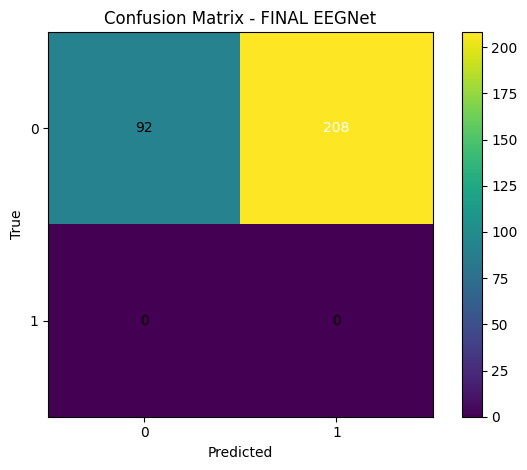

[DONE] Final model evaluation complete.


In [10]:
# =======================================================================================
# Cell 6: Confusion Matrix & Metrics on TEST (FINAL EEGNet)
# =======================================================================================

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Utility functions
# ------------------------------------------------------------------
def compute_metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    eps = 1e-12
    acc  = (tp + tn) / (tp + tn + fp + fn + eps)
    prec = tp / (tp + fp + eps)
    rec  = tp / (tp + fn + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)
    return acc, prec, rec, f1

def plot_confusion_matrix(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.xticks([0, 1], ['0', '1'])
    plt.yticks([0, 1], ['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')

    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            plt.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Validate upstream artifacts
# ------------------------------------------------------------------
print("[CHECK] Verifying predictions and labels are available...")

if 'y_pred' not in globals():
    raise RuntimeError(
        "Predictions 'y_pred' not found. "
        "Please run Cell 5 (final model inference) first."
    )

if 'yte' not in globals():
    raise RuntimeError(
        "Test labels 'yte' not found. "
        "Please run Cell 5 first."
    )

print(f"[CHECK] Found predictions for {len(y_pred)} test segments.")

# ------------------------------------------------------------------
# Confusion Matrix & Metrics (FINAL model)
# ------------------------------------------------------------------
cm = confusion_matrix(yte, y_pred, labels=[0, 1])
acc, prec, rec, f1 = compute_metrics_from_cm(cm)

print("\n[FINAL MODEL] ===== TEST RESULTS (SEGMENT-LEVEL) =====")
print("Confusion Matrix (rows=true [0,1], cols=pred [0,1]):")
print(cm)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

plot_confusion_matrix(cm, title="Confusion Matrix - FINAL EEGNet")

print("[DONE] Final model evaluation complete.")
